In [3]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

In [4]:
# wrapper
def potential(resolution, threshold = 1e-6, radius = 0.33, problem='cylinder', method='CG', v_init = 1, bump=False, x_left=-1, x_right=1, y_left=-1, y_right=1):
    x_list = np.linspace(x_left, x_right, resolution)
    y_list = np.linspace(y_left, y_right, resolution)
    xx, yy = np.meshgrid(x_list, y_list)
    
    v = np.zeros(shape=(resolution, resolution))
    
    # shape and mask
    cylinder = np.zeros(shape=v.shape, dtype='bool')    
    cylinder[xx**2 + yy**2 < radius**2] = True
    
    mask = cylinder.copy()
    mask[:0]=True;mask[:,-1]=True;mask[0,:]=True;mask[-1,:]=True
    
    shape = cylinder.copy()
    
    if (problem=='cylinder'):
        v[shape] = v_init
    if (problem=='heatwall'):
        shape[xx==x_left] = True
        num_it = 10
        v = np.zeros(shape=(resolution, ))
        
    if (bump):
        radius_bump = 0.1*radius
        cx = radius
        cy = 0
        shape[(xx-cx)**2 + (yy-cy)**2 < radius_bump**2] = True
        v[shape] = v_init        
    
    if (method=='relax'):
        out0, out1 = relax(v, threshold, shape, v_init)
        return out0, out1, xx, yy
    if (method=='CG'):
        out0, out1 = CG(v, threshold, mask, shape, v_init)
        return out0, out1, xx, yy
    if (method=='analytic'):
        assert(problem=='cylinder')
        assert(bump==False)
        return analytic_cylinder(radius, v_init, xx, yy), 1, xx, yy

In [5]:
def relax(V, threshold, shape, v_init):
    num_it=0
    isConverge=False
    v=V.copy()
    vnew=v.copy()
    
    while(not isConverge):
        
        vnew=v.copy()
        
        num_it+=1
        vnew[1:-2, 1:-2] = (vnew[0:-3,1:-2]+vnew[2:-1,1:-2]+vnew[1:-2,0:-3]+vnew[1:-2:,2:-1])/4.0
        vnew[shape] = v_init
        
        if (num_it % 10 == 0): # faster
            isConverge=isConverge_rtr(v, vnew, threshold)
        
        v=vnew

    return v, num_it

def isConverge_it(old, new, threshold):
    for x, y in zip(old.flatten(), new.flatten()):
        if np.abs(x-y) > threshold:
            return False
    return True
def isConverge_rtr(old, new, threshold):
    err = np.sum(np.abs(old-new))
    if err < threshold:
        return True
    return False

In [6]:
def CG(v, threshold, mask, shape, v_init):
    
    v2 = v.copy()
    b = np.zeros(v.shape)
    b[1:-2, 1:-2] = -(v[0:-3,1:-2]+v[2:-1,1:-2]+v[1:-2,0:-3]+v[1:-2:,2:-1])/4.0    
    r=b-Ax(0*v,mask)
    p=r.copy()
    
    num_it = 0
    isConverge=False
    err = np.sum(r*r)
    while(not isConverge):
        num_it+=1
        Ap=(Ax(p, mask))
        rtr=np.sum(r*r)
        alpha=rtr/np.sum(Ap*p)
        v2+=alpha*p
        v2[shape]=v_init
        rnew=r-alpha*Ap
        beta=np.sum(rnew*rnew)/rtr
        p=rnew+beta*p
        r=rnew
        
        #if (num_it%10==0):
            #isConverge = isConverge_it(v, v2, threshold)
        #v=v2
        isConverge = rtr < threshold
        
    return v2, num_it
        
def Ax(V, mask):
    Vuse=V.copy()
    Vuse[mask] = 0
    ans = np.zeros(shape=V.shape)
    ans[1:-2, 1:-2]=(Vuse[0:-3,1:-2]+Vuse[2:-1,1:-2]+Vuse[1:-2,0:-3]+Vuse[1:-2:,2:-1])/4.0
    ans[1:-2, 1:-2]-= V[1:-2, 1:-2]
    return ans

In [7]:
def analytic_cylinder(radius, v_init, xx, yy):
    v = np.zeros(shape=xx.shape)
    v -= np.log((xx**2 + yy**2) / radius)
    v[xx**2 + yy**2 < radius**2] = v_init
    return v

In [8]:
def charge_density(v):
    rho = np.zeros(shape=v.shape)
    rho[1:-2, 1:-2] = v[1:-2, 1:-2]-(v[0:-3,1:-2]+v[2:-1,1:-2]+v[1:-2,0:-3]+v[1:-2:,2:-1])/4.0
    return rho

In [22]:
from scipy import interpolate

def interpolate_v(x, y, v, resolution, scaling_factor):
    x_i = np.linspace(-1, 1, resolution*scaling_factor)
    y_i = np.linspace(-1, 1, resolution*scaling_factor)
    xx, yy = np.meshgrid(x_i, y_i)
    
    xx_i, yy_i = np.meshgrid(x_i, y_i)
    
    v_interp = interpolate.RectBivariateSpline(x, y, v, s=scaling_factor, kx=5, ky=5)
    return  xx_i, yy_i, v_interp(x_i, y_i)

In [19]:
def electric_field(v):
    grad = np.gradient(v)
    norm = np.sqrt(grad[0]**2 + grad[1]**2)
    return norm

<IPython.core.display.Javascript object>


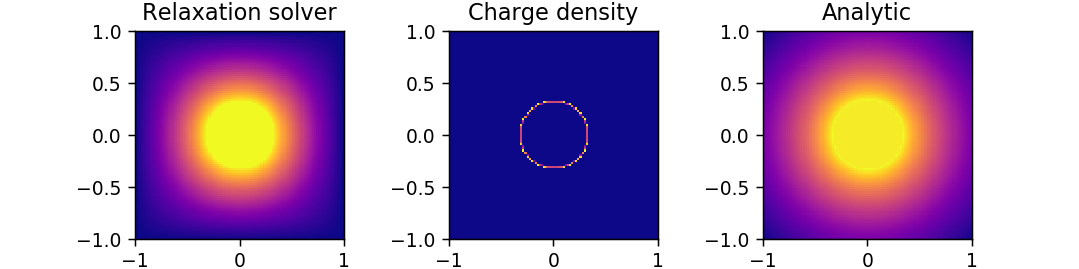

Relaxation solver takes 9050+- 5 steps to converge


Text(0.5, 1.0, 'Analytic')

In [20]:
# 1
resolution = 100

cmap="plasma"
fig, axs = plt.subplots(1, 3, figsize=(8,2))
plt.subplots_adjust(wspace=0.5)

v, it, xx, yy = potential(resolution, method='relax')
print("Relaxation solver takes " + str(it) + "+- 5 steps to converge")
axs[0].pcolor(xx, yy, v, cmap=cmap)
axs[0].set_title('Relaxation solver')

axs[1].pcolor(xx, yy, charge_density(v), cmap=cmap)
axs[1].set_title('Charge density')

v, it, xx, yy = potential(resolution, method='analytic')
axs[2].pcolor(xx, yy, v, cmap=cmap)
axs[2].set_title('Analytic')

<IPython.core.display.Javascript object>


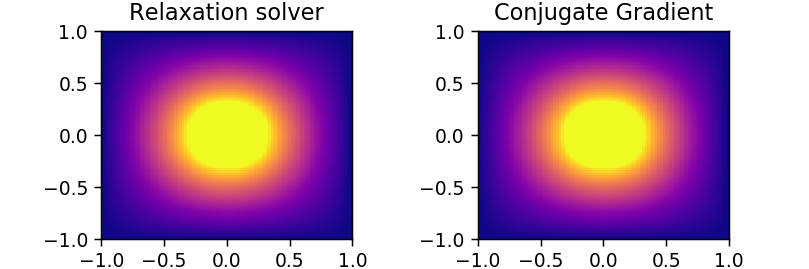

Relaxation solver takes 9050+-5 steps to converge
Conjugate gradient solver takes 100 steps to converge


Text(0.5, 1.0, 'Conjugate Gradient')

In [12]:
# 2
resolution = 100

cmap="plasma"
fig, axs = plt.subplots(1, 2, figsize=(6,2))
plt.subplots_adjust(wspace=0.5)

v, it, xx, yy = potential(resolution, method='relax')
print("Relaxation solver takes " + str(it) + "+-5 steps to converge")
axs[0].pcolor(xx, yy, v, cmap=cmap)
axs[0].set_title('Relaxation solver')

v, it, xx, yy = potential(resolution, method='CG')
print("Conjugate gradient solver takes " + str(it) + " steps to converge")
axs[1].pcolor(xx, yy, v, cmap=cmap)
axs[1].set_title('Conjugate Gradient')

<IPython.core.display.Javascript object>


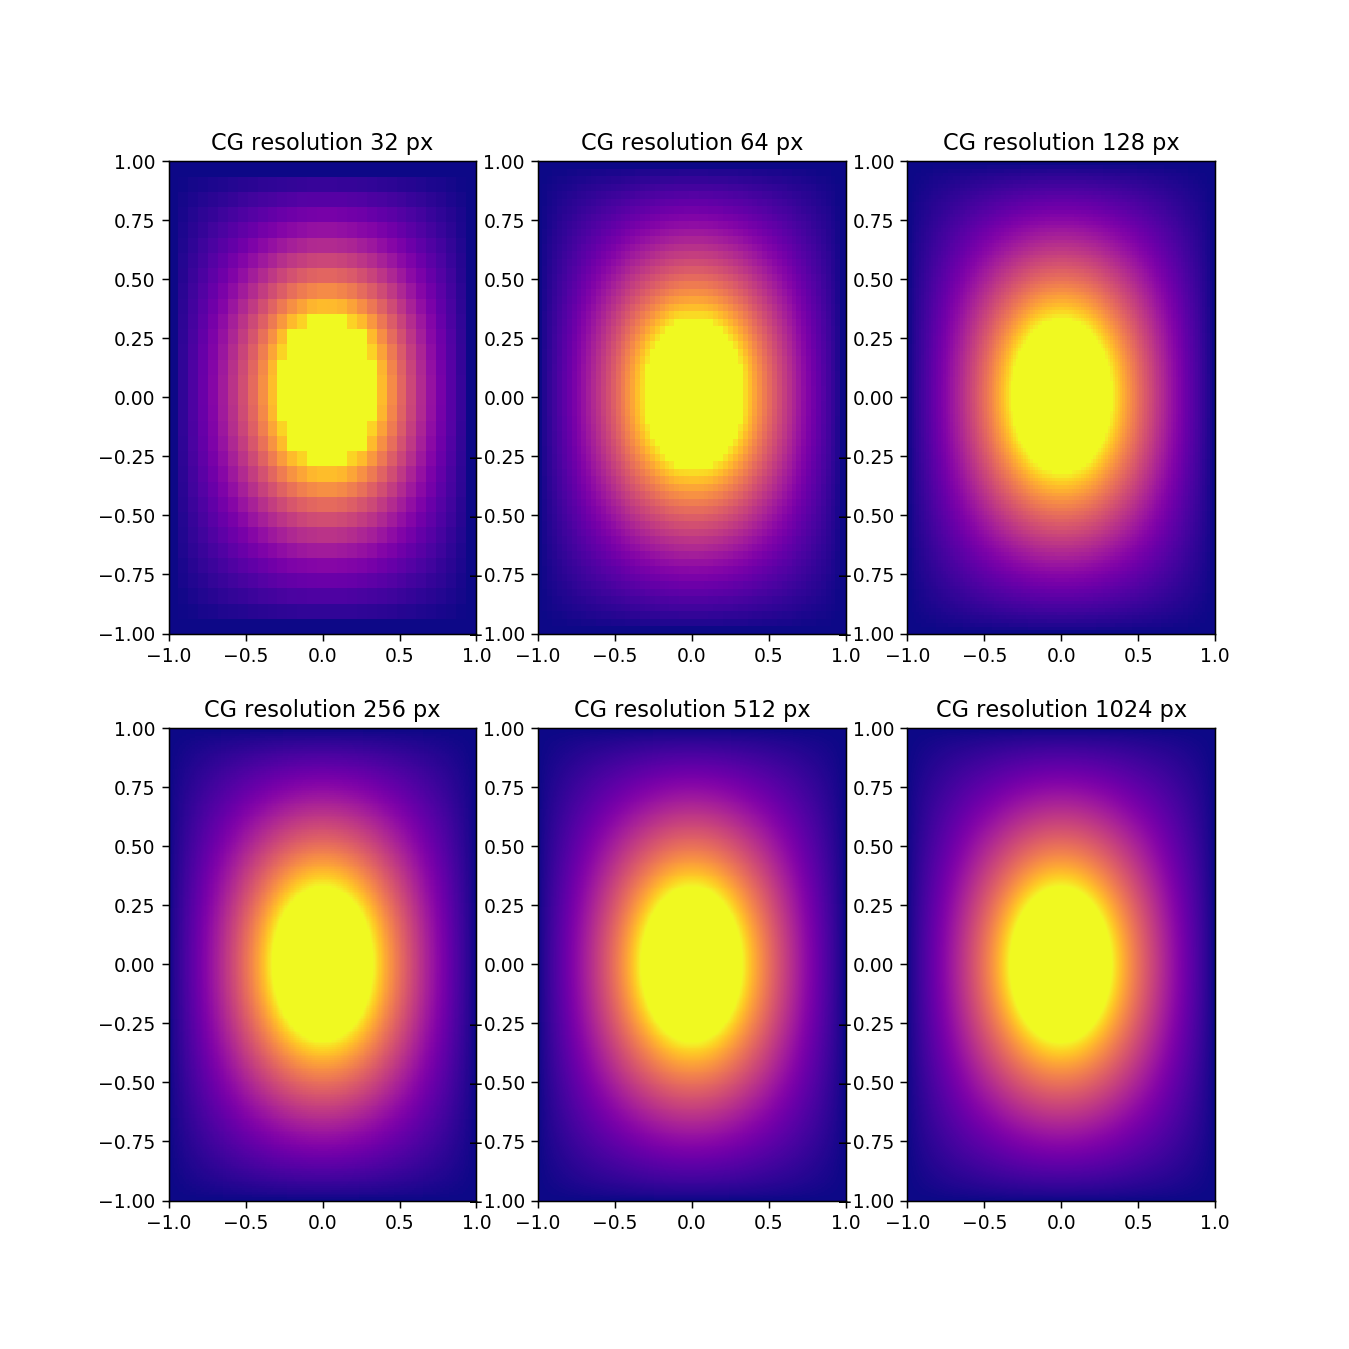

Conjugate gradient takes 0.002954721450805664 s to solve 32 px
Conjugate gradient takes 0.014959573745727539 s to solve 64 px
Conjugate gradient takes 0.04886984825134277 s to solve 128 px
Conjugate gradient takes 0.506645917892456 s to solve 256 px
Conjugate gradient takes 10.763212203979492 s to solve 512 px
Conjugate gradient takes 95.1853895187378 s to solve 1024 px


Text(0.5, 1.0, 'CG resolution 1024 px')

In [21]:
# 3
import time

fig, axs = plt.subplots(2, 3, figsize=(10, 10))

resolution = 32
t_init = time.time()
v, it, xx, yy = potential(resolution, method='CG')
print("Conjugate gradient takes " + str(time.time() - t_init) + " s to solve " + str(resolution) + " px")
axs[0, 0].pcolor(xx, yy, v, cmap=cmap)
axs[0, 0].set_title('CG resolution ' + str(resolution) + " px")

resolution = 64
t_init = time.time()
v, it, xx, yy = potential(resolution, method='CG')
print("Conjugate gradient takes " + str(time.time() - t_init) + " s to solve " + str(resolution) + " px")
axs[0, 1].pcolor(xx, yy, v, cmap=cmap)
axs[0, 1].set_title('CG resolution ' + str(resolution) + " px")

resolution = 128
t_init = time.time()
v, it, xx, yy = potential(resolution, method='CG')
print("Conjugate gradient takes " + str(time.time() - t_init) + " s to solve " + str(resolution) + " px")
axs[0, 2].pcolor(xx, yy, v, cmap=cmap)
axs[0, 2].set_title('CG resolution ' + str(resolution) + " px")

resolution = 256
t_init = time.time()
v, it, xx, yy = potential(resolution, method='CG')
print("Conjugate gradient takes " + str(time.time() - t_init) + " s to solve " + str(resolution) + " px")
axs[1, 0].pcolor(xx, yy, v, cmap=cmap)
axs[1, 0].set_title('CG resolution ' + str(resolution) + " px")

resolution = 512
t_init = time.time()
v, it, xx, yy = potential(resolution, method='CG')
print("Conjugate gradient takes " + str(time.time() - t_init) + " s to solve " + str(resolution) + " px")
axs[1, 1].pcolor(xx, yy, v, cmap=cmap)
axs[1, 1].set_title('CG resolution ' + str(resolution) + " px")

resolution = 1024
t_init = time.time()
v, it, xx, yy = potential(resolution, method='CG')
print("Conjugate gradient takes " + str(time.time() - t_init) + " s to solve " + str(resolution) + " px")
axs[1, 2].pcolor(xx, yy, v, cmap=cmap)
axs[1, 2].set_title('CG resolution ' + str(resolution) + " px")


<IPython.core.display.Javascript object>


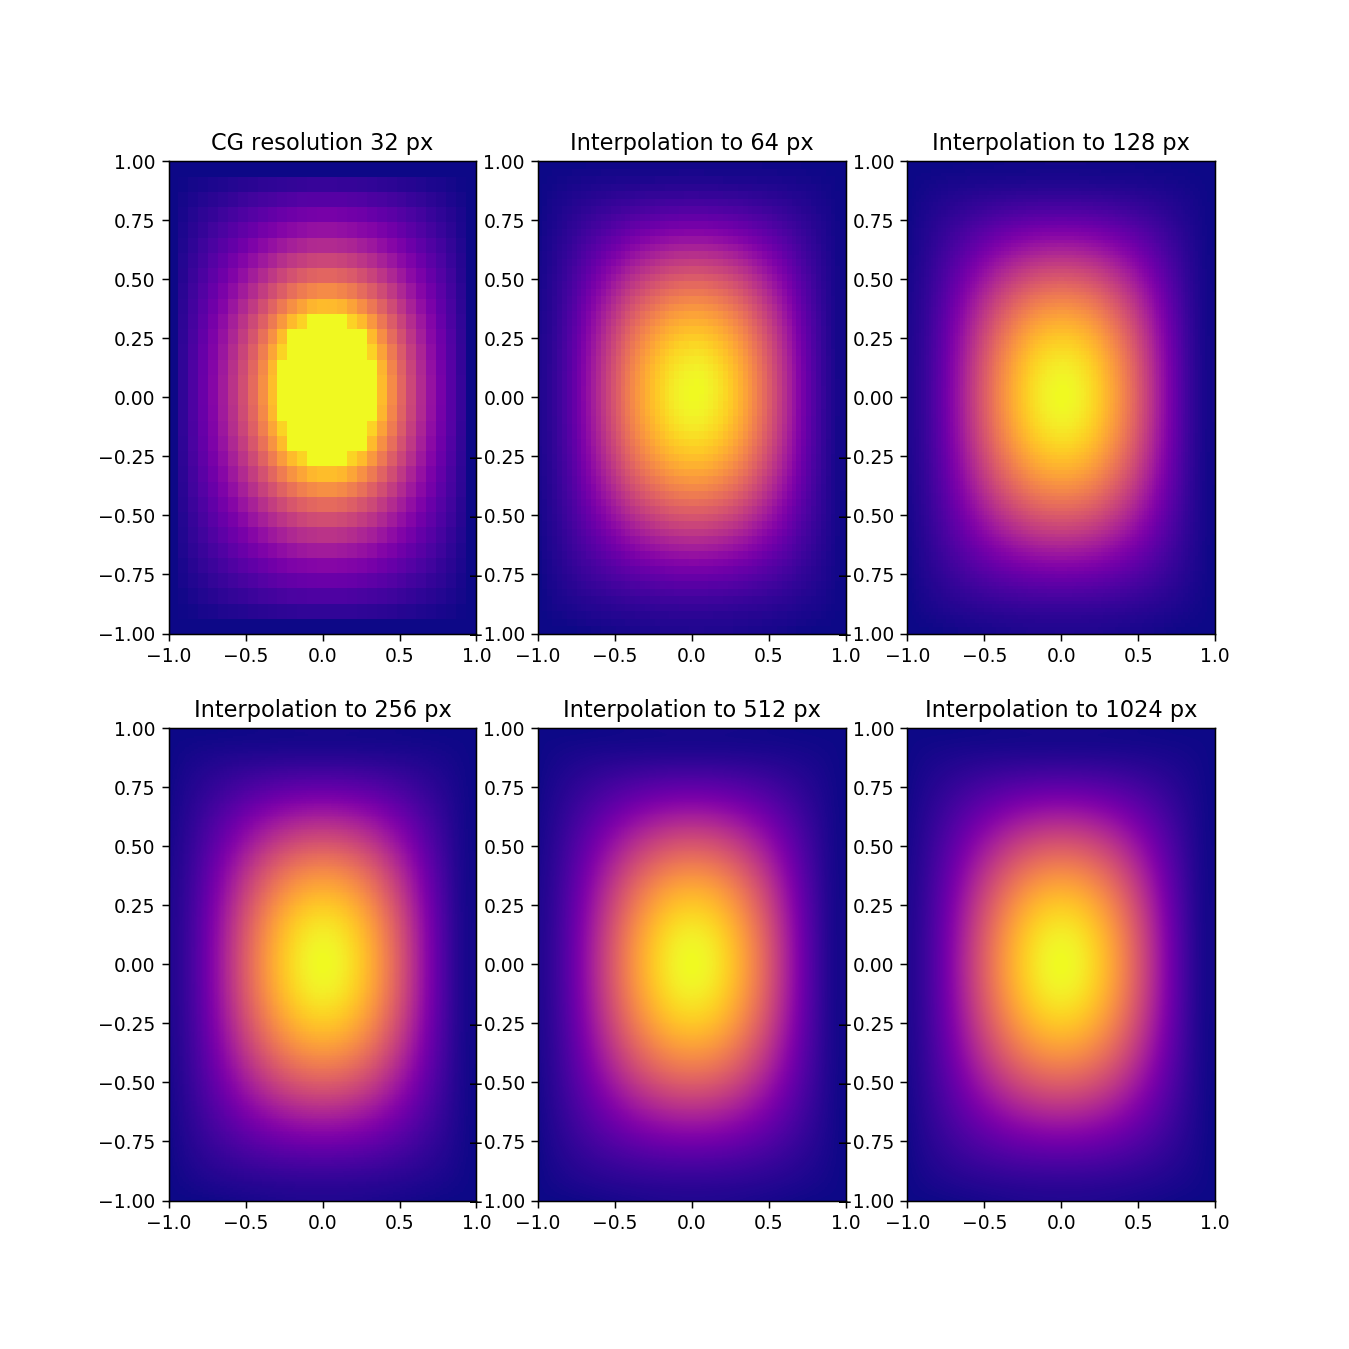

Conjugate gradient takes 0.00598454475402832 s to solve 32 px
Interpolation from 32 px to 64 takes 0.009941339492797852 s
Interpolation from 32 px to 128 takes 0.00797891616821289 s
Interpolation from 32 px to 256 takes 0.012965917587280273 s
Interpolation from 32 px to 512 takes 0.020978927612304688 s
Interpolation from 32 px to 1024 takes 0.06782054901123047 s


Text(0.5, 1.0, 'Interpolation to 1024 px')

In [23]:
import time

fig, axs = plt.subplots(2, 3, figsize=(10, 10))

resolution = 32

t_init = time.time()
v, it, xx, yy = potential(resolution, method='CG')
t_cg = time.time() - t_init
print("Conjugate gradient takes " + str(t_cg) + " s to solve " + str(resolution) + " px")
axs[0, 0].pcolor(xx, yy, v, cmap=cmap)
axs[0, 0].set_title('CG resolution ' + str(resolution) + " px")

t_init = time.time()
factor=2
xx_i, yy_i, v_i = interpolate_v(xx[0,:], yy[:,0], v, resolution, factor)
print("Interpolation from 32 px to " + str(32*factor) + " takes " + str(time.time() - t_init + t_cg) + " s")
axs[0, 1].pcolor(xx_i, yy_i, v_i, cmap=cmap)
axs[0, 1].set_title('Interpolation to ' + str(resolution*factor) + " px")

t_init = time.time()
factor=4
xx_i, yy_i, v_i = interpolate_v(xx[0,:], yy[:,0], v, resolution, factor)
print("Interpolation from 32 px to " + str(32*factor) + " takes " + str(time.time() - t_init + t_cg) + " s")
axs[0, 2].pcolor(xx_i, yy_i, v_i, cmap=cmap)
axs[0, 2].set_title('Interpolation to ' + str(resolution*factor) + " px")

t_init = time.time()
factor=8
xx_i, yy_i, v_i = interpolate_v(xx[0,:], yy[:,0], v, resolution, factor)
print("Interpolation from 32 px to " + str(32*factor) + " takes " + str(time.time() - t_init + t_cg) + " s")
axs[1, 0].pcolor(xx_i, yy_i, v_i, cmap=cmap)
axs[1, 0].set_title('Interpolation to ' + str(resolution*factor) + " px")

t_init = time.time()
factor=16
xx_i, yy_i, v_i = interpolate_v(xx[0,:], yy[:,0], v, resolution, factor)
print("Interpolation from 32 px to " + str(32*factor) + " takes " + str(time.time() - t_init + t_cg) + " s")
axs[1, 1].pcolor(xx_i, yy_i, v_i, cmap=cmap)
axs[1, 1].set_title('Interpolation to ' + str(resolution*factor) + " px")

t_init = time.time()
factor=32
xx_i, yy_i, v_i = interpolate_v(xx[0,:], yy[:,0], v, resolution, factor)
print("Interpolation from 32 px to " + str(32*factor) + " takes " + str(time.time() - t_init + t_cg) + " s")
axs[1, 2].pcolor(xx_i, yy_i, v_i, cmap=cmap)
axs[1, 2].set_title('Interpolation to ' + str(resolution*factor) + " px")

<IPython.core.display.Javascript object>


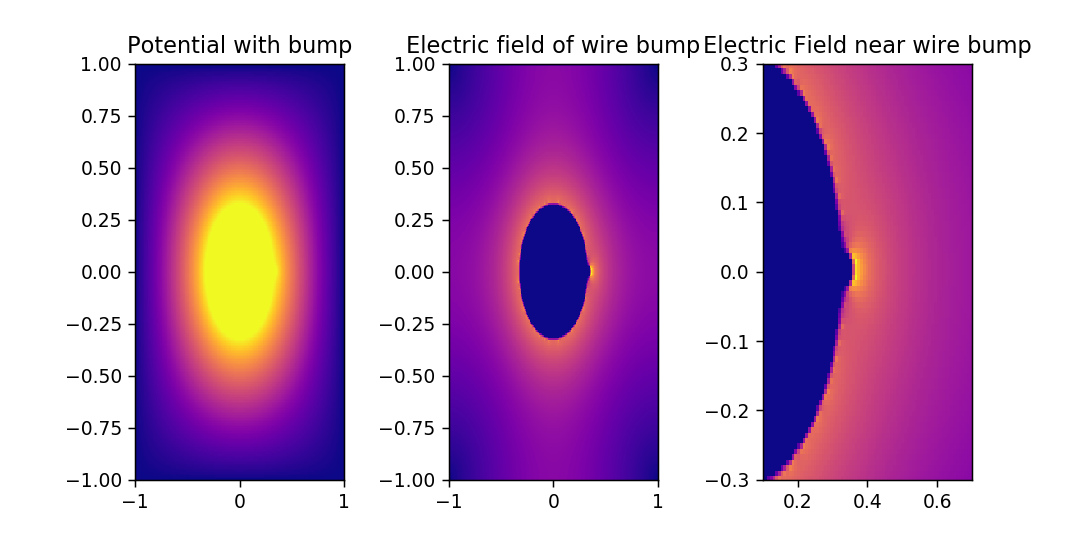

Text(0.5, 1.0, 'Electric Field near wire bump')

In [15]:
# 4
resolution = 256

cmap="plasma"
fig, axs = plt.subplots(1, 3, figsize=(8,4))
plt.subplots_adjust(wspace=0.5)

v, it, xx, yy = potential(resolution, method='relax', bump=True)
axs[0].pcolor(xx, yy, v, cmap=cmap)
axs[0].set_title('Potential with bump')


efield = electric_field(v)
axs[1].pcolor(xx, yy, efield, cmap=cmap)
axs[1].set_title('Electric field of wire bump')

axs[2].pcolor(xx, yy, efield, cmap=cmap)
axs[2].set_xlim([0.1, 0.7])
axs[2].set_ylim([-0.3, 0.3])
axs[2].set_title('Electric Field near wire bump')